In [1]:
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import model
import model_conv
from tqdm import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import os

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/')
import cellbgnet
import cellbgnet.utils

from cellbgnet.datasets import DataSimulator
from cellbgnet.utils.hardware import cpu, gpu
from cellbgnet.model import CellBGModel
from cellbgnet.simulation.psf_kernel import SMAPSplineCoefficient
from cellbgnet.generic.emitter import EmitterSet
from cellbgnet.train_loss_infer import generate_probmap_cells

os.chdir('/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src')

from skimage.io import imread
from skimage.measure import label
import random
import edt
from skimage.filters import gaussian
from scipy.ndimage import rotate
import random
import pickle
import pathlib
from pathlib import Path
#%matplotlib qt5


In [3]:
print(os.getcwd())

/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/src


In [4]:
param_file = '../../../cellbgnet/utils/reference_files/reference_Axel.yaml'
param = cellbgnet.utils.param_io.ParamHandling().load_params(param_file)


In [5]:
psf_params = param.PSF.to_dict()
simulation_params = param.Simulation.to_dict()
hardware_params = param.Hardware.to_dict()
train_size = simulation_params['train_size']
calib_file = psf_params['calib_file']


In [6]:
psf_size = 41
xextent = [-0.5, 127.5]
yextent = [-0.5, 127.5]
zextent = [-400, 400]
scale = torch.tensor([(xextent[1] - xextent[0]),
                      (yextent[1] - yextent[0]),
                      (zextent[1] - zextent[0])])
shift = torch.tensor([xextent[0], yextent[0], zextent[0]])



In [7]:
psf = SMAPSplineCoefficient(calib_file=calib_file).init_spline(
xextent=[-0.5, 63.5], yextent=[-0.5, 63.5], img_shape=[64, 64], device='cuda', 
roi_size=None, roi_auto_center=None, normalize=True)


INITIATING CUDA IMPLEMENTATION


In [8]:
epochs = 40
batch_size = 128
lr = 0.0001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# transforms
transform = transforms.Compose([
    transforms.ToTensor(),
])


In [10]:
# train and validation data
train_data = datasets.MNIST(
    root='../input/data',
    train=True,
    download=True,
    transform=transform
)
val_data = datasets.MNIST(
    root='../input/data',
    train=False,
    download=True,
    transform=transform
)

In [11]:
def create_psf_batch(size=64, batch_size=128):
    xyz = torch.normal(float(size/2), float(size/4), (batch_size,3))
    xyz[:, 2] = 0.0
    xyz = xyz.view(1, -1, 3)
    photon_scale = 100
    #photons = torch.rand((xyz.shape[1], 1))*photon_scale
    photons = torch.ones((xyz.shape[1], 1))*photon_scale
    frames = torch.cat([psf.forward(xyz[:,i,...], photons[i]) for i in range(xyz.shape[1])])
    max_val = torch.max(frames)
    frames = frames/max_val
    frames = frames.view(frames.shape[0],1,frames.shape[1], frames.shape[2])
    return frames, xyz, photons


In [12]:
frames,_, _ = create_psf_batch()

In [13]:
def create_batch(size=28, batch_size=64):
    batch = torch.zeros([batch_size,1,size,size])
    xys = torch.tensor([[0], [0]])
    xs = torch.randint(0, size, (batch_size,))
    ys = torch.randint(0, size,  (batch_size,))
    xys = torch.concatenate([xs.view(-1,1), ys.view(-1,1)], dim=1)
    batch[torch.arange(batch.shape[0]),0, xs, ys] = 1
    return batch, xys

In [14]:
model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_beta4.pt")

#model = model_conv.VAE(zDim=2, featureDim=32*56*56, imsize=(64,64)).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')


In [15]:
#model = torch.load("/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_1.pt")


In [16]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)

    A beta here will affect how much the KLD matters

    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD*4, BCE, KLD

In [17]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i in range((64*64)//batch_size):
        data = create_psf_batch()
        data, xyz, _ = data
        data = data.to(device)
        #data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss, BCE, KLD = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    train_loss = running_loss/(64*64)
    return train_loss

In [18]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_BCE = 0.0
    running_KLD = 0.0
    with torch.no_grad():
        for i in range((64*64)//batch_size):
            data = create_psf_batch()
            data, xys, _ = data
            data = data.to(device)
            #data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss, BCE, KLD = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
            running_BCE += BCE.item()
            running_KLD += KLD.item()
            # save the last batch input and output of every epoch
            if ((64*64)//batch_size - 1) and (epoch % 100 == 0):
                #plt.imshow(data.view(batch_size, 1, 64, 64)[0,0,...].cpu().detach().numpy(), cmap='gray')
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                                  reconstruction.view(batch_size, 1, 64, 64)[:8]))
                save_image(both.cpu(), f"../outputs/conv_out/psf_beta4_conv_output{epoch}.png", nrow=num_rows, pad_value=1)

    val_loss = running_loss/(64*64)
    bce_loss_tot = running_BCE/(64*64)
    kld_loss = running_KLD/(64*64)
    return val_loss, mu, xys, bce_loss_tot, kld_loss

In [46]:
train_loss = []
val_loss = []
bce_loss_list = []
kld_loss_list = []
curr = 177
epochs = 30000
for epoch in range(curr, curr+epochs+1):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, 0)
    val_epoch_loss, mu, xys, bce_loss, kld_loss = validate(model, 0)
    bce_loss_list.append(bce_loss)
    kld_loss_list.append(kld_loss)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"BCE: {bce_loss:.4f}, KLD: {kld_loss:.4f}")
    if epoch % 5000 == 0:
        torch.save(model.state_dict(), f"/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_B4_{epoch}.pt")


Epoch 178 of 30000
Train Loss: 161.7119
BCE: 142.0343, KLD: 4.9150
Epoch 179 of 30000
Train Loss: 162.0249
BCE: 143.3067, KLD: 4.9916
Epoch 180 of 30000
Train Loss: 161.6033
BCE: 143.1485, KLD: 4.7366
Epoch 181 of 30000
Train Loss: 162.1470
BCE: 142.6976, KLD: 4.8417
Epoch 182 of 30000
Train Loss: 161.7628
BCE: 142.5212, KLD: 4.7598
Epoch 183 of 30000
Train Loss: 161.1540
BCE: 142.1591, KLD: 4.9198
Epoch 184 of 30000
Train Loss: 160.8451
BCE: 142.0292, KLD: 4.9046
Epoch 185 of 30000
Train Loss: 162.4287
BCE: 141.9435, KLD: 4.9420
Epoch 186 of 30000
Train Loss: 161.0027
BCE: 140.9340, KLD: 4.8639
Epoch 187 of 30000
Train Loss: 160.5219
BCE: 142.5507, KLD: 4.9110
Epoch 188 of 30000
Train Loss: 160.7565
BCE: 141.7474, KLD: 4.9084
Epoch 189 of 30000
Train Loss: 160.6916
BCE: 141.2692, KLD: 4.8026
Epoch 190 of 30000
Train Loss: 160.7181
BCE: 140.9008, KLD: 4.7981
Epoch 191 of 30000
Train Loss: 161.7384
BCE: 140.2069, KLD: 4.9171
Epoch 192 of 30000
Train Loss: 160.6489
BCE: 141.2119, KLD: 4.

KeyboardInterrupt: 

In [48]:
torch.save(model, "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_beta4.pt")
torch.save(model.state_dict(), "/home/axtr7550/Chromosome_project/cellbgnet/Axel_notebook/VAE_tutorial/outputs/models/VAE_conv_PSF_beta4_sd.pt")

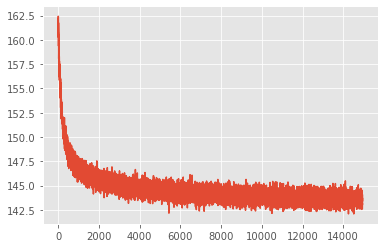

In [47]:
plt.plot(list(range(len(train_loss))), train_loss)


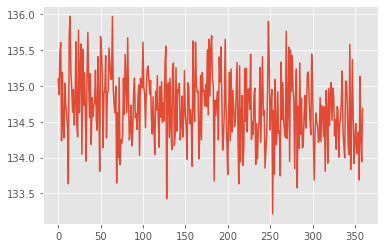

In [66]:
plt.plot(list(range(len(train_loss))), train_loss)


In [19]:
torch.cuda.empty_cache()

In [43]:
all_xys.shape
all_mus.shape

torch.Size([11000, 2])

In [19]:
images, xys, _ = create_psf_batch(batch_size=100)
model.eval()
images = images.to(device)
reconstruction, mu, logvar = model(images)
all_xys = xys
all_mus = mu
for i in range(100):
    images, xys, _ = create_psf_batch(batch_size=100)
    model.eval()
    images = images.to(device)
    reconstruction, mu, logvar = model(images)
    del reconstruction
    del images

    all_xys = torch.cat((all_xys, xys), dim=1)
    del xys
    all_mus = torch.cat((all_mus, mu), dim=0)
    del mu


In [20]:
yin = (all_xys[0,:,1]>-1) & (all_xys[0,:,1]<64)
xin = (all_xys[0,:,0]>-1) & (all_xys[0,:,0]<64)
both_in = xin&yin


In [19]:
predicted = all_mus[both_in,0].cpu().detach().numpy()
x = all_xys[0,both_in,1]


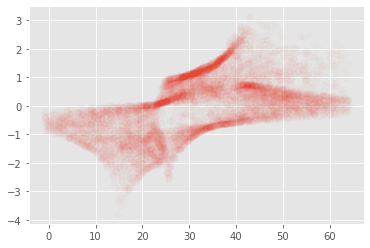

In [20]:
plt.plot(x, predicted, 'o', alpha=0.01)


In [21]:
predicted = all_mus[both_in,1].cpu().detach().numpy()
x = all_xys[0,both_in,0]


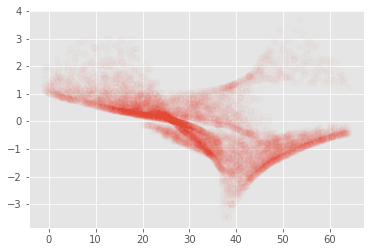

In [22]:
plt.plot(x, predicted, 'o', alpha=0.01)


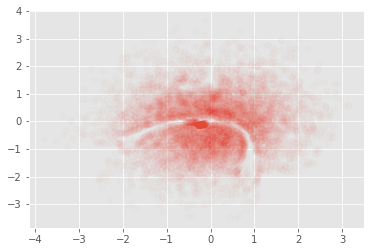

In [23]:
plt.plot(all_mus[:,0].cpu().detach().numpy(), all_mus[:,1].cpu().detach().numpy(), 'o', alpha=0.01)

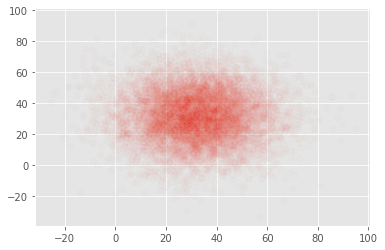

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.plot(all_xys[0,:,0].cpu().detach().numpy(), all_xys[0,:,1].cpu().detach().numpy(), 'o', alpha=0.01)


In [37]:
images.max()

tensor(2.1374, device='cuda:0')

In [ ]:
#both = torch.cat((data.view(batch_size, 1, 64, 64)[:8], 
                    reconstruction.view(batch_size, 1, 64, 64)[:8]))
#save_image(both.cpu(), f"../outputs/psf_output{epoch}.png", nrow=num_rows)


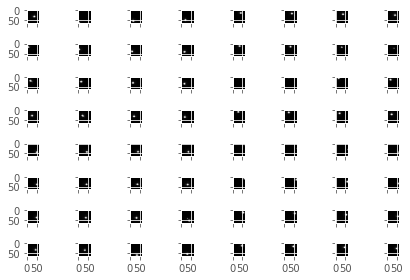

In [144]:
model.eval()
fig, axs = plt.subplots(8,8, sharex=True, sharey=True)
# decoding
fig.tight_layout()
for i in range(-4,4):
    for j in range(-4,4):
        z = torch.tensor([[float(i),float(j)]]).cuda()
        axs[i,j].imshow(reconstruction.view((64, 64)).cpu().detach().numpy(), cmap='gray')

plt.show()


In [137]:
reconstruction.view((64, 64))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 4.0368e-01, 3.2587e-01,
         2.6970e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 6.7344e-01, 4.9652e-01,
         3.5723e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 9.4673e-01, 8.1915e-01,
         6.0063e-01],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 2.4258e-36, 3.9615e-36,
         4.5398e-36],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 5.4501e-39, 7.5286e-39,
         5.2027e-39],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], device='cuda:0', grad_fn=<ViewBackward0>)

In [156]:
from sklearn.linear_model import LinearRegression
import pandas as pd
from statsmodels.formula.api import ols
predictions = all_mus[both_in,:].cpu().detach().numpy()
X = np.array(all_xys[0,both_in,:2])



train_X, test_X, train_Y, test_Y = skl.model_selection.train_test_split(predictions, X, test_size=0.2)
reg = LinearRegression().fit(np.concatenate([train_X, train_X**2], axis=1), train_Y)
error = np.sqrt(np.mean((reg.predict(np.concatenate([test_X, test_X**2], axis=1)) - test_Y)**2))
print(error)

10.768504


In [154]:
df = pd.DataFrame(np.concatenate([predictions, X], axis=1), columns=["mux", "muy", "X", "Y"])
df

,mux,muy,X,Y
0,0.590835,-1.088881,33.769619,43.261154
1,-0.235529,-0.463075,54.439774,59.142441
2,-0.100780,0.574154,11.446047,17.861872
3,0.686940,-0.091562,28.948713,24.942631
4,-0.082744,0.470603,13.443804,19.228218
...,...,...,...,...
9241,0.283223,-1.349000,38.934818,42.622536
9242,0.330101,-0.425184,28.774563,54.524624
9243,0.308841,0.478308,13.271326,27.912254
9244,-0.767542,2.720012,50.244900,12.440348


In [157]:
model = ols("X, Y ~ mux + muy", data=df)

type: Number of rows mismatch between data argument and X, Y (9246 versus 2)
    X, Y ~ mux + muy
    ^^^^

In [86]:
mus = torch.cat((torch.arange(-2,3,0.5).repeat(10).view(-1,1),torch.arange(-2,3,0.5).repeat_interleave(10).view(-1,1)),1)

In [87]:
model.eval()
z = mus.float().cuda()

reconstruction = model.decoder(z)


In [88]:
save_image(reconstruction.view((10*10, 1, 64,64)).cpu(), f"../outputs/conv_out/psf_beta4_test_values.png", nrow=10, pad_value=1)

In [204]:
reconstruction.shape

torch.Size([169, 4096])

In [64]:
from model_2_layer import simple_nn
simple_model = simple_nn()
lr = 0.001
optimizer_simple = optim.Adam(simple_model.parameters(), lr=lr)
loss_simple = nn.MSELoss()

Hej


In [65]:
def fit_simple(simple_model, train_X, train_Y):
    simple_model.train()
    running_loss = 0.0
    train_X = train_X.to(device)
    train_Y = train_Y.to(device)    
    batch_size = 64
    for i in range(len(train_X)//batch_size):
        data = train_X[i*batch_size:(i+1)*batch_size]
        gt = train_Y[i*batch_size:(i+1)*batch_size]
        optimizer_simple.zero_grad()
        output = simple_model(data)
        loss = loss_simple(output, gt)
        running_loss += loss.item()
        loss.backward()
        optimizer_simple.step()

    train_loss = running_loss/len(train_X)
    return train_loss



In [72]:
def validate_simple(model, test_X, test_y):
    model.eval()
    running_loss = 0.0
    batch_size = 64
    test_X = test_X.to(device)
    test_y = test_y.to(device)    


    with torch.no_grad():
        for i in range(len(test_X)//batch_size):
            data = test_X[i*batch_size:(i+1)*batch_size]
            gt = test_y[i*batch_size:(i+1)*batch_size]
            output = simple_model(data)
            loss = loss_simple(output, gt)
            running_loss += loss.item()

    val_loss = running_loss/len(test_X)
    return val_loss

In [98]:
import sklearn.model_selection as model_selection

predictions = all_mus[both_in,:]
X = all_xys[0,both_in,:2]
train_X, test_X, train_Y, test_Y = model_selection.train_test_split(predictions, X, test_size=0.2, shuffle=True, random_state=42)
#loss_vec = []
#val_loss_vec = []
simple_model.to(device)
train_X = train_X.detach()
test_X = test_X.detach()
for epoch in range(80):
    loss = fit_simple(simple_model, train_X, train_Y)
    loss_vec.append(loss)
    val_loss = validate_simple(simple_model, test_X, test_Y)
    val_loss_vec.append(val_loss)
    

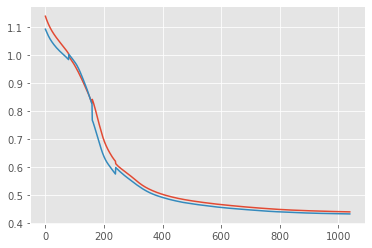

In [99]:
plt.plot(list(range(len(loss_vec))), loss_vec)
plt.plot(list(range(len(loss_vec))), val_loss_vec)

In [101]:
np.sqrt(val_loss_vec[-1])

0.6587733752300137